In [1]:
# Import required Dependencies
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import datetime

# Pre Processing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from functools import partial

# Error Metrics
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.inspection import DecisionBoundaryDisplay

# Classifiers
from sklearn import svm
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# DL models
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils

# Save models
import pickle

#Cross Validation 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Parallel backend processing
from concurrent.futures import ProcessPoolExecutor
from joblib import parallel_backend

In [2]:
import os

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "CC"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, bbox_inches='tight')

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 2021 data

In [3]:
# Load the saved sample of data in CSV format for 2021 as train data
df = pd.read_csv('CC_data_resample.csv')

In [4]:
df.head()

,blue,dbsi,evi,gi,gndvi,green,kndvi,ndci,ndpi,ndvigb,...,rvi1,rvi2,sipi,srpi,tvi,vari,VH,VV-VH,VV,class
0,420.0,-0.182015,1.618649,1.097070,0.496850,599.0,0.274648,0.258152,0.348913,0.175662,...,3.263736,2.974958,0.618529,0.769231,10744.0,0.073103,0.012528,8.969604,0.112369,2.0
1,343.0,-0.113368,1.268323,1.076621,0.472570,548.0,0.245611,0.290592,0.387367,0.230079,...,3.005894,2.791971,0.633743,0.673870,62820.0,0.054622,0.009737,8.673847,0.084453,2.0
2,341.0,-0.250545,1.339956,1.171315,0.464481,588.0,0.268044,0.257945,0.273626,0.265877,...,3.203187,2.734694,0.650077,0.679283,4264.0,0.114820,0.008923,9.209814,0.082180,2.0
3,336.0,-0.315290,1.837561,1.297674,0.525106,558.0,0.358986,0.328649,0.297671,0.248322,...,4.167442,3.211470,0.684211,0.781395,21304.0,0.196319,0.005892,16.092522,0.094815,2.0
4,329.0,-0.254732,2.047013,1.357143,0.511478,532.0,0.361496,0.367742,0.360577,0.235772,...,4.198980,3.093985,0.666835,0.839286,15304.0,0.235294,0.010234,12.326612,0.126151,2.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2311488 entries, 0 to 2311487
Data columns (total 25 columns):
 #   Column  Dtype  
---  ------  -----  
 0   blue    float64
 1   dbsi    float64
 2   evi     float64
 3   gi      float64
 4   gndvi   float64
 5   green   float64
 6   kndvi   float64
 7   ndci    float64
 8   ndpi    float64
 9   ndvigb  float64
 10  ndvi    float64
 11  nir     float64
 12  npci    float64
 13  psri    float64
 14  red     float64
 15  rvi1    float64
 16  rvi2    float64
 17  sipi    float64
 18  srpi    float64
 19  tvi     float64
 20  vari    float64
 21  VH      float64
 22  VV-VH   float64
 23  VV      float64
 24  class   float64
dtypes: float64(25)
memory usage: 440.9 MB


In [6]:
df.describe()

,blue,dbsi,evi,gi,gndvi,green,kndvi,ndci,ndpi,ndvigb,...,rvi1,rvi2,sipi,srpi,tvi,vari,VH,VV-VH,VV,class
count,2.311488e+06,2.311488e+06,2.311488e+06,2.311488e+06,2.311488e+06,2.311488e+06,2.311488e+06,2.311488e+06,2.311488e+06,2.311488e+06,...,2.311488e+06,2.311488e+06,2.311488e+06,2.311488e+06,2.311488e+06,2.311488e+06,2.311488e+06,2.311488e+06,2.311488e+06,2311488.0
mean,3.788445e+02,-2.497862e-01,2.020292e+00,1.453894e+00,6.512780e-01,6.241995e+02,4.761289e-01,3.583120e-01,4.588809e-01,2.614761e-01,...,9.373468e+00,5.767140e+00,7.674252e-01,8.303713e-01,3.226307e+04,7.782638e+00,1.830850e-02,7.324447e+00,9.593845e-02,1.5
std,1.855067e+02,1.554535e-01,1.965226e+01,1.131360e+00,1.497559e-01,2.035687e+02,1.856416e-01,1.376394e-01,1.090051e-01,8.635219e-02,...,2.516122e+01,3.723462e+00,1.381105e-01,2.984677e-01,1.884807e+04,1.967303e+01,1.206974e-02,9.999259e+00,7.654909e-02,0.5
min,1.000000e+00,-9.346241e-01,-2.726833e+04,3.344482e-03,-1.666667e-01,1.000000e+00,0.000000e+00,-2.911392e-01,-7.920937e-01,-9.944904e-01,...,6.658163e-01,7.142857e-01,-2.158273e-01,4.854369e-03,0.000000e+00,0.000000e+00,4.897626e-05,1.523661e-02,2.100922e-04,1.0
25%,2.770000e+02,-3.492517e-01,1.715183e+00,1.164228e+00,5.881579e-01,5.020000e+02,3.917501e-01,2.765957e-01,4.004267e-01,2.045455e-01,...,4.605364e+00,3.856287e+00,7.251842e-01,6.914894e-01,1.591200e+04,1.916084e-01,9.628372e-03,3.019870e+00,4.870462e-02,1.0
50%,3.488894e+02,-2.897484e-01,2.188730e+00,1.402597e+00,6.860497e-01,6.020000e+02,5.278769e-01,3.672627e-01,4.760726e-01,2.564103e-01,...,7.555556e+00,5.370504e+00,8.076286e-01,8.014354e-01,3.188800e+04,3.326572e-01,1.559603e-02,4.994045e+00,8.286895e-02,1.5
75%,4.360000e+02,-1.944158e-01,2.512675e+00,1.706840e+00,7.580288e-01,7.090000e+02,6.192802e-01,4.586777e-01,5.309829e-01,3.117207e-01,...,1.240000e+01,7.265539e+00,8.608696e-01,9.414634e-01,4.848800e+04,4.928910e-01,2.404580e-02,8.410636e+00,1.262599e-01,2.0
max,9.088000e+03,5.492288e-01,1.770000e+03,4.690000e+02,9.994809e-01,8.608000e+03,1.000000e+00,9.972028e-01,9.987179e-01,9.955157e-01,...,5.304000e+03,3.852000e+03,9.996201e-01,3.490000e+02,6.553200e+04,6.342039e+02,2.529018e-01,3.231396e+03,2.422261e+01,2.0


In [7]:
df['class'].value_counts()

2.0    1155744
1.0    1155744
Name: class, dtype: int64

In [8]:
np.isinf(df).values.sum()

0

In [9]:
df.isnull().sum()

blue      0
dbsi      0
evi       0
gi        0
gndvi     0
green     0
kndvi     0
ndci      0
ndpi      0
ndvigb    0
ndvi      0
nir       0
npci      0
psri      0
red       0
rvi1      0
rvi2      0
sipi      0
srpi      0
tvi       0
vari      0
VH        0
VV-VH     0
VV        0
class     0
dtype: int64

# Data Preparation for Model Building

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Train and test sets: 2021

In [11]:
# Creating training and test sets
# Splitting the data into train and test
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Rescaling the features
scaler=MinMaxScaler()
X=scaler.fit_transform(X)

# train test split with train_size=80% and test_size=20%
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1849190, 24)
(462298, 24)
(1849190,)
(462298,)


In [13]:
df_X = pd.DataFrame(X_test)
df_X

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.027072,0.361531,0.939129,0.003918,0.823210,0.061694,0.651677,0.616079,0.712576,0.683588,...,0.034888,0.002886,0.002067,0.916736,0.002435,0.109809,0.000668,0.068176,0.000500,0.001156
1,0.037196,0.402427,0.939128,0.003243,0.787493,0.069130,0.597077,0.532371,0.717232,0.637866,...,0.047244,0.001902,0.001646,0.877526,0.002470,0.616065,0.000499,0.144721,0.000389,0.001914
2,0.031253,0.493036,0.939116,0.002839,0.761323,0.061926,0.546902,0.494442,0.766475,0.652520,...,0.048334,0.001428,0.001417,0.869354,0.002028,0.733199,0.000326,0.093514,0.001116,0.003534
3,0.046550,0.488754,0.939106,0.002445,0.633780,0.075520,0.363914,0.435667,0.670241,0.605854,...,0.068443,0.000672,0.000769,0.752731,0.002133,0.725508,0.000169,0.307820,0.000601,0.006285
4,0.036426,0.371459,0.939139,0.003502,0.788536,0.060881,0.610234,0.554422,0.698486,0.612910,...,0.038522,0.002076,0.001656,0.865623,0.002968,0.243118,0.000634,0.049454,0.000400,0.000669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462293,0.064378,0.464685,0.939103,0.002215,0.668327,0.100500,0.372354,0.378064,0.654684,0.596645,...,0.100545,0.000693,0.000896,0.770290,0.002007,0.561985,0.000050,0.129321,0.001543,0.006752
462294,0.061957,0.587130,0.939063,0.002096,0.355411,0.108865,0.058172,0.350376,0.541658,0.624868,...,0.115082,0.000183,0.000245,0.562552,0.001685,0.545993,0.077974,0.018658,0.006314,0.004009
462295,0.037636,0.374868,0.939136,0.003838,0.784793,0.071337,0.620852,0.555074,0.706944,0.642418,...,0.041187,0.002239,0.001620,0.878121,0.002868,0.769883,0.000705,0.076042,0.002287,0.005885
462296,0.043909,0.470396,0.939131,0.003027,0.747619,0.071802,0.546641,0.457585,0.747583,0.607740,...,0.052574,0.001426,0.001316,0.834937,0.002621,0.991699,0.000444,0.135222,0.002715,0.012417


## Classifiers

### GridSearch/RandomSearch or testing many parameters each classifier

In [4]:
def set_grid(est, param, cv = 10):
    cv = GridSearchCV(
        estimator = est,
        param_grid = param,
        cv = cv,
        scoring = "accuracy",
        verbose = 10,
        n_jobs = -1
    )
    return cv

def set_rand(est, param, cv = 10):
    cv = RandomizedSearchCV(
        estimator = est,
        param_distributions = param,
        cv = cv,
        scoring = "accuracy",
        verbose = 10,
        n_jobs = 5
    )
    return cv

def print_results(model_cv, X_test_s, y_test):
    return (model_cv.best_score_, model_cv.best_params_, model_cv.score(X_test_s, y_test))

def print_result(model):
    return (model_cv.best_params_)

In [5]:
#CC = df.class.unique()
CC = ['Maize', 'Rice']
CC

['Maize', 'Rice']

In [6]:
all_classes = CC + ['Other']
all_classes

['Maize', 'Rice', 'Other']

## Generating noise to the original data to represent 'Others' class

In [378]:
# Extract features and labels from half of the original data as we want to generate only half
df_half = df.sample(frac=0.5)
X_org = df_half.iloc[:, :-1]
y_org = df_half.iloc[:, -1]

# Set the number of synthetic samples you want to generate (Half of the data to be equal class 1 or 2)
num_synthetic_samples = X_org.shape[0]
print(num_synthetic_samples)

# Specify the mean and standard deviation for the noise
mu, sigma = 0, 0.1

# Generate synthetic noise with the same dimension as the original features
synthetic_noise = np.random.normal(mu, sigma, size=(num_synthetic_samples, 24))

# Create synthetic samples by adding noise to the original features
synthetic_samples = X_org + synthetic_noise
print(synthetic_samples.shape)

# Label the synthetic samples as "Others" (or any label you prefer)
synthetic_labels = pd.Series([3] * num_synthetic_samples, name=y_org.name)
#synthetic_labels = pd.Series(np.tile([3], num_synthetic_samples), name=y_org.name)
print(synthetic_labels.shape)

# Combine the original and synthetic data
new_df = pd.concat([synthetic_samples.reset_index(drop=True), synthetic_labels.reset_index(drop=True)], axis=1)
print(new_df.shape)
augmented_data = pd.concat([df.reset_index(drop=True), new_df.reset_index(drop=True)])
print(augmented_data.shape)

# Save the augmented dataset
augmented_data.to_csv("CC_augmented_data.csv", index=False)

1155744
(1155744, 24)
(1155744,)
(1155744, 25)
(3467232, 25)


## 2021 Augmented data

In [7]:
# Load the saved sample of data in CSV format for 2021 as train data
df_aug = pd.read_csv('CC_augmented_data.csv')

In [8]:
df_aug.head()

,blue,dbsi,evi,gi,gndvi,green,kndvi,ndci,ndpi,ndvigb,...,rvi1,rvi2,sipi,srpi,tvi,vari,VH,VV-VH,VV,class
0,420.0,-0.182015,1.618649,1.097070,0.496850,599.0,0.274648,0.258152,0.348913,0.175662,...,3.263736,2.974958,0.618529,0.769231,10744.0,0.073103,0.012528,8.969604,0.112369,2.0
1,343.0,-0.113368,1.268323,1.076621,0.472570,548.0,0.245611,0.290592,0.387367,0.230079,...,3.005894,2.791971,0.633743,0.673870,62820.0,0.054622,0.009737,8.673847,0.084453,2.0
2,341.0,-0.250545,1.339956,1.171315,0.464481,588.0,0.268044,0.257945,0.273626,0.265877,...,3.203187,2.734694,0.650077,0.679283,4264.0,0.114820,0.008923,9.209814,0.082180,2.0
3,336.0,-0.315290,1.837561,1.297674,0.525106,558.0,0.358986,0.328649,0.297671,0.248322,...,4.167442,3.211470,0.684211,0.781395,21304.0,0.196319,0.005892,16.092522,0.094815,2.0
4,329.0,-0.254732,2.047013,1.357143,0.511478,532.0,0.361496,0.367742,0.360577,0.235772,...,4.198980,3.093985,0.666835,0.839286,15304.0,0.235294,0.010234,12.326612,0.126151,2.0


In [9]:
df_aug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3467232 entries, 0 to 3467231
Data columns (total 25 columns):
 #   Column  Dtype  
---  ------  -----  
 0   blue    float64
 1   dbsi    float64
 2   evi     float64
 3   gi      float64
 4   gndvi   float64
 5   green   float64
 6   kndvi   float64
 7   ndci    float64
 8   ndpi    float64
 9   ndvigb  float64
 10  ndvi    float64
 11  nir     float64
 12  npci    float64
 13  psri    float64
 14  red     float64
 15  rvi1    float64
 16  rvi2    float64
 17  sipi    float64
 18  srpi    float64
 19  tvi     float64
 20  vari    float64
 21  VH      float64
 22  VV-VH   float64
 23  VV      float64
 24  class   float64
dtypes: float64(25)
memory usage: 661.3 MB


In [10]:
df_aug.describe()

,blue,dbsi,evi,gi,gndvi,green,kndvi,ndci,ndpi,ndvigb,...,rvi1,rvi2,sipi,srpi,tvi,vari,VH,VV-VH,VV,class
count,3.467232e+06,3.467232e+06,3.467232e+06,3.467232e+06,3.467232e+06,3.467232e+06,3.467232e+06,3.467232e+06,3.467232e+06,3.467232e+06,...,3.467232e+06,3.467232e+06,3.467232e+06,3.467232e+06,3.467232e+06,3.467232e+06,3.467232e+06,3.467232e+06,3.467232e+06,3.467232e+06
mean,3.788147e+02,-2.498711e-01,2.025408e+00,1.453569e+00,6.512251e-01,6.241696e+02,4.760884e-01,3.583229e-01,4.588374e-01,2.614786e-01,...,9.367552e+00,5.766855e+00,7.674496e-01,8.302521e-01,3.226953e+04,7.787143e+00,1.831552e-02,7.327970e+00,9.600633e-02,2.000000e+00
std,1.855543e+02,1.658152e-01,1.611100e+01,1.105831e+00,1.605258e-01,2.035727e+02,1.944163e-01,1.492360e-01,1.233942e-01,1.038736e-01,...,2.491942e+01,3.999415e+00,1.497180e-01,2.739005e-01,1.884669e+04,1.968197e+01,5.896424e-02,1.015245e+01,9.669593e-02,8.164967e-01
min,6.649370e-01,-1.096173e+00,-2.726833e+04,-3.284531e-02,-2.674063e-01,1.000000e+00,-4.188174e-01,-4.190372e-01,-9.587276e-01,-9.944904e-01,...,5.238605e-01,6.879161e-01,-2.738239e-01,-2.120017e-01,-2.038291e-01,-3.614009e-01,-4.797642e-01,-3.736762e-02,-4.111960e-01,1.000000e+00
25%,2.770000e+02,-3.546255e-01,1.711691e+00,1.159908e+00,5.747765e-01,5.020000e+02,3.805259e-01,2.674163e-01,3.905429e-01,1.964854e-01,...,4.605210e+00,3.855176e+00,7.089911e-01,6.880071e-01,1.592400e+04,1.896024e-01,7.184722e-03,3.021160e+00,4.284088e-02,1.000000e+00
50%,3.487339e+02,-2.856330e-01,2.187130e+00,1.404846e+00,6.830136e-01,6.020000e+02,5.237998e-01,3.667582e-01,4.737281e-01,2.569779e-01,...,7.556522e+00,5.370769e+00,8.038109e-01,8.037037e-01,3.189200e+04,3.333333e-01,1.573140e-02,4.995420e+00,8.461265e-02,2.000000e+00
75%,4.360000e+02,-1.829821e-01,2.513941e+00,1.709080e+00,7.629382e-01,7.090000e+02,6.211531e-01,4.636449e-01,5.372411e-01,3.211991e-01,...,1.239721e+01,7.264755e+00,8.656898e-01,9.480367e-01,4.849200e+04,5.013405e-01,2.989678e-02,8.413568e+00,1.382617e-01,3.000000e+00
max,9.088029e+03,7.388367e-01,1.770000e+03,4.690000e+02,1.312550e+00,8.608000e+03,1.304162e+00,1.221380e+00,1.077875e+00,1.254667e+00,...,5.304218e+03,3.852000e+03,1.336948e+00,3.490000e+02,6.553223e+04,6.342039e+02,5.513598e-01,3.231421e+03,2.422261e+01,3.000000e+00


In [11]:
df_aug['class'].value_counts()

2.0    1155744
1.0    1155744
3.0    1155744
Name: class, dtype: int64

In [12]:
np.isinf(df_aug).values.sum()

0

In [13]:
df_aug.isnull().sum()

blue      0
dbsi      0
evi       0
gi        0
gndvi     0
green     0
kndvi     0
ndci      0
ndpi      0
ndvigb    0
ndvi      0
nir       0
npci      0
psri      0
red       0
rvi1      0
rvi2      0
sipi      0
srpi      0
tvi       0
vari      0
VH        0
VV-VH     0
VV        0
class     0
dtype: int64

## Train and test sets: 2021 Augmented data

In [14]:
# Separate features (X) and labels (y)
X_new = df_aug.iloc[:, :-1]
y_new = df_aug.iloc[:, -1]

# Apply MinMax scaling
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_new), columns=X_new.columns)

# Apply horizontal flipping
X_flipped_horizontal = pd.DataFrame(np.fliplr(X_scaled.values), columns=X_new.columns)

# Multiply the labels (y) by 2
y_aug = pd.concat([y_new] * 2, axis=0, ignore_index=True)

# Concatenate the augmented features
X_aug = pd.concat([X_scaled, X_flipped_horizontal], axis=0, ignore_index=True)

In [15]:
# Save the scaler object
with open('models/CC/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [16]:
print(X_aug.shape)
print(y_aug.shape)

(6934464, 24)
(6934464,)


In [17]:
# Concatenate the augmented features and labels
df_aug_flp = pd.concat([X_aug, y_aug], axis=1, ignore_index=False)
df_aug_flp.head()

,blue,dbsi,evi,gi,gndvi,green,kndvi,ndci,ndpi,ndvigb,...,rvi1,rvi2,sipi,srpi,tvi,vari,VH,VV-VH,VV,class
0,0.046145,0.498176,0.939102,0.002409,0.483720,0.069478,0.402481,0.412815,0.642070,0.520263,...,0.000517,0.000594,0.553991,0.002810,0.163952,0.000685,0.477432,0.002787,0.021254,2.0
1,0.037672,0.535585,0.939090,0.002365,0.468352,0.063553,0.385627,0.432591,0.660951,0.544457,...,0.000468,0.000546,0.563436,0.002537,0.958612,0.000656,0.474725,0.002696,0.020121,2.0
2,0.037451,0.460830,0.939092,0.002567,0.463233,0.068200,0.398647,0.412689,0.605103,0.560373,...,0.000505,0.000531,0.573576,0.002552,0.065070,0.000750,0.473936,0.002862,0.020028,2.0
3,0.036901,0.425547,0.939109,0.002837,0.501604,0.064715,0.451429,0.455791,0.616909,0.552568,...,0.000687,0.000655,0.594767,0.002845,0.325094,0.000879,0.470997,0.004992,0.020541,2.0
4,0.036131,0.458548,0.939117,0.002964,0.492979,0.061694,0.452886,0.479621,0.647797,0.546988,...,0.000693,0.000625,0.583980,0.003010,0.233536,0.000940,0.475208,0.003826,0.021813,2.0


In [18]:
# Creating training and test sets
# Splitting the data into train and test
X_aug_flp = df_aug_flp.iloc[:, :-1]
y_aug_flp = df_aug_flp.iloc[:, -1]

# Rescaling the features
#scaler=MinMaxScaler()
#X_aug=scaler.fit_transform(X_aug)

# train test split with train_size=80% and test_size=20%
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_aug_flp, y_aug_flp, train_size=0.80, random_state=101)
print(X_train_aug.shape)
print(X_test_aug.shape)
print(y_train_aug.shape)
print(y_test_aug.shape)
print("Unique values in y_train_aug:", y_train_aug.unique())
print("Unique values in y_test_aug:", y_test_aug.unique())

(5547571, 24)
(1386893, 24)
(5547571,)
(1386893,)
Unique values in y_train_aug: [3. 2. 1.]
Unique values in y_test_aug: [1. 2. 3.]


### Classifiers

Apply different classifiers on the augemented data, as it has 3 classes (Maize, Rice and Others)

### KNeighborsClassifier

In [19]:
knn = KNeighborsClassifier()
param_cv = {"n_neighbors" : range(3, 6)}

knn_cv = set_rand(knn, param_cv)
knn_cv.get_params()

{'cv': 10,
 'error_score': nan,
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 5,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'estimator': KNeighborsClassifier(),
 'n_iter': 10,
 'n_jobs': 5,
 'param_distributions': {'n_neighbors': range(3, 6)},
 'pre_dispatch': '2*n_jobs',
 'random_state': None,
 'refit': True,
 'return_train_score': False,
 'scoring': 'accuracy',
 'verbose': 10}

In [20]:
print(datetime.datetime.now())
with parallel_backend('multiprocessing'):
    knn_cv.fit(X_train_aug, y_train_aug)
print(datetime.datetime.now())

2024-06-10 21:38:23.897368
Fitting 10 folds for each of 3 candidates, totalling 30 fits
2024-06-11 09:06:55.983861


In [21]:
print_results(knn_cv, X_test_aug, y_test_aug)

(0.897203839263257, {'n_neighbors': 3}, 0.8988083435420036)

In [22]:
print(datetime.datetime.now())
y_pred_knn = knn_cv.predict(X_test_aug)
print(datetime.datetime.now())

2024-06-11 12:53:04.200740
2024-06-11 14:01:06.385919


In [23]:
# evaluation: Confusion Matrix
confusion_knn = metrics.confusion_matrix(y_true = y_test_aug, y_pred = y_pred_knn)
confusion_knn

array([[415224,  47017,      7],
       [ 56740, 405573,      6],
       [ 17407,  19165, 425754]], dtype=int64)

Saving figure KNeighbors_cm


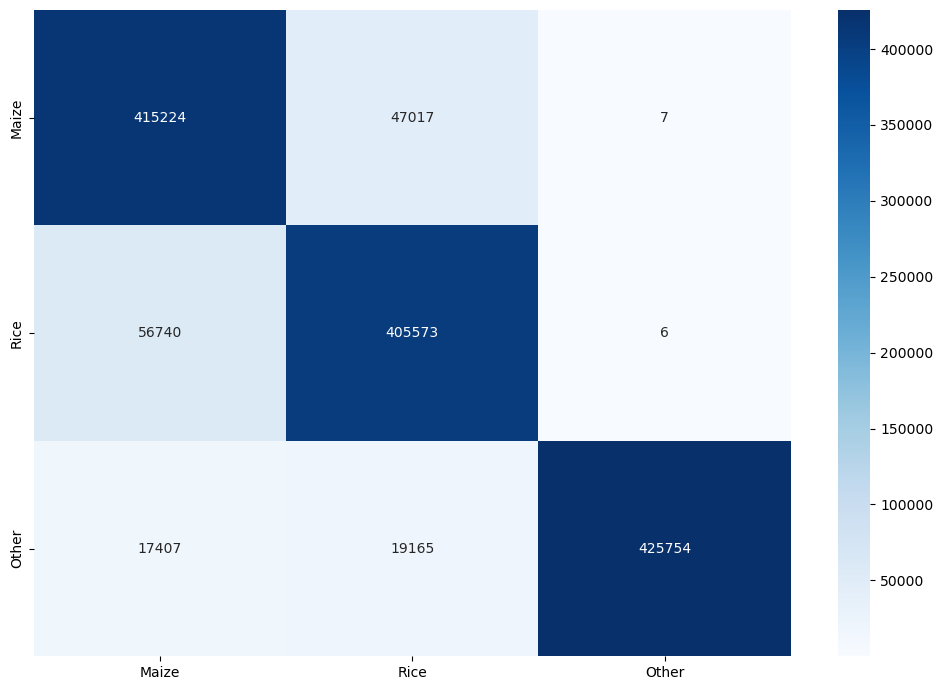

In [24]:
df_cm_knn = pd.DataFrame(confusion_knn, index = [i for i in all_classes],
                  columns = [i for i in all_classes])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_knn, annot=True,fmt='d',cmap=plt.cm.Blues)
save_fig("KNeighbors_cm")

In [25]:
# measure accuracy
print('Accuracy: %.3f' % metrics.accuracy_score(y_true=y_test_aug, y_pred=y_pred_knn))
print('Recall: %.3f' % metrics.recall_score(y_true=y_test_aug, y_pred=y_pred_knn, average='weighted'))
print('Precision: %.3f' % metrics.precision_score(y_true=y_test_aug, y_pred=y_pred_knn, average='weighted'))
print('F1-Score: %.3f' % metrics.f1_score(y_true=y_test_aug, y_pred=y_pred_knn, average='weighted'))

Accuracy: 0.899
Recall: 0.899
Precision: 0.903
F1-Score: 0.900


In [26]:
# Save model as pkl file 
pickle.dump(knn_cv, open('models/CC/knn_cv.pkl', 'wb'))
#pickled_model = pickle.load(open('models/CC/knn_cv.pkl', 'rb'))
#pickled_model.predict(X_test)

### DecisionTreeClassifier

In [20]:
dt = DecisionTreeClassifier(criterion='entropy')
param_cv = {"max_depth" : [20, 22, 25], "min_samples_split" : [50,80,100]}
dt_cv = set_rand(dt, param_cv)
dt_cv.get_params

<bound method BaseEstimator.get_params of RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(criterion='entropy'),
                   n_jobs=5,
                   param_distributions={'max_depth': [20, 22, 25],
                                        'min_samples_split': [50, 80, 100]},
                   scoring='accuracy', verbose=10)>

In [21]:
print(datetime.datetime.now())
with parallel_backend('multiprocessing'):
    dt_cv.fit(X_train_aug, y_train_aug)
print(datetime.datetime.now())

2024-06-10 11:16:17.005417
Fitting 10 folds for each of 9 candidates, totalling 90 fits
2024-06-10 13:27:00.301943


In [22]:
print_results(dt_cv, X_test_aug, y_test_aug)

(0.9177229096443149,
 {'min_samples_split': 50, 'max_depth': 25},
 0.9181818640659373)

In [23]:
print(datetime.datetime.now())
y_pred_dt = dt_cv.predict(X_test_aug)
print(datetime.datetime.now())

2024-06-10 13:34:19.213160
2024-06-10 13:34:19.558976


In [26]:
# evaluation: Confusion Matrix
confusion_dt = metrics.confusion_matrix(y_true = y_test_aug, y_pred = dt_cv.predict(X_test_aug))
confusion_dt

array([[417282,  42579,   2387],
       [ 55218, 405027,   2074],
       [  7168,   4047, 451111]], dtype=int64)

Saving figure Decision_tree_cm


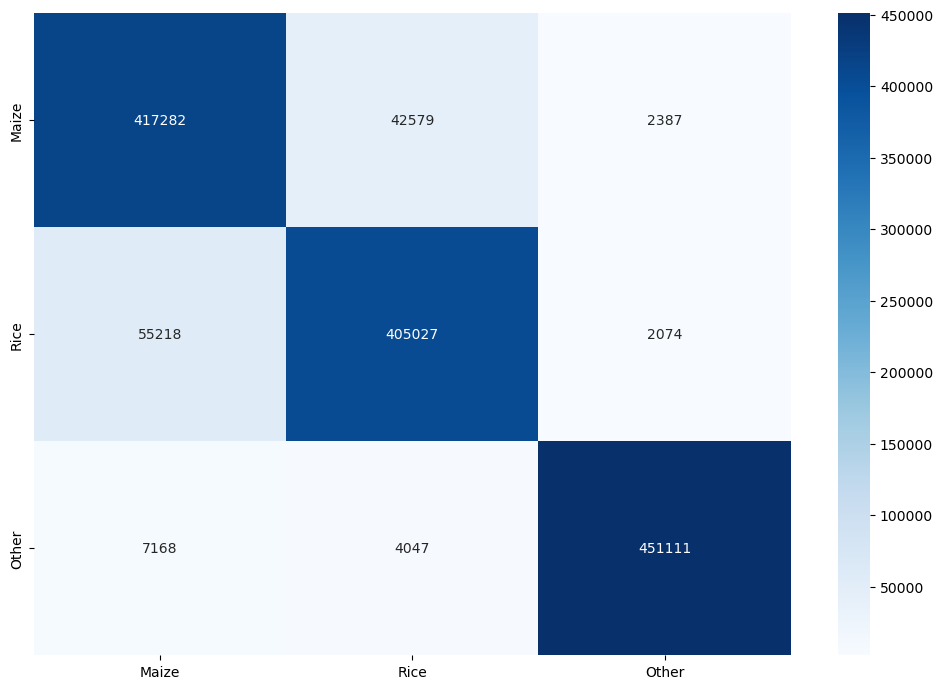

In [27]:
df_cm_dt = pd.DataFrame(confusion_dt, index = [i for i in all_classes],
                  columns = [i for i in all_classes])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_dt, annot=True,fmt='d',cmap=plt.cm.Blues)
save_fig("Decision_tree_cm")

In [28]:
# measure accuracy
print('Accuracy: %.3f' % metrics.accuracy_score(y_true=y_test_aug, y_pred=y_pred_dt))
print('Recall: %.3f' % metrics.recall_score(y_true=y_test_aug, y_pred=y_pred_dt, average='weighted'))
print('Precision: %.3f' % metrics.precision_score(y_true=y_test_aug, y_pred=y_pred_dt, average='weighted'))
print('F1-Score: %.3f' % metrics.f1_score(y_true=y_test_aug, y_pred=y_pred_dt, average='weighted'))

Accuracy: 0.918
Recall: 0.918
Precision: 0.919
F1-Score: 0.918


In [29]:
# Save model as pkl file 
pickle.dump(dt_cv, open('models/CC/dt_cv.pkl', 'wb'))
#pickled_model = pickle.load(open('models/CC/dt_cv.pkl', 'rb'))
#pickled_model.predict(X_test_aug)

### RandomForestClassifier

In [403]:
rf = RandomForestClassifier(criterion='entropy', min_samples_split=80)
param_cv = {"n_estimators" : [500, 700, 1000], "max_depth" : [20, 22, 25]}
rf_cv = set_rand(rf, param_cv)
rf_cv.get_params()

{'cv': 10,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'entropy',
 'estimator__max_depth': None,
 'estimator__max_features': 'sqrt',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 80,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(criterion='entropy', min_samples_split=80),
 'n_iter': 10,
 'n_jobs': -1,
 'param_distributions': {'n_estimators': [500, 700, 1000],
  'max_depth': [20, 22, 25]},
 'pre_dispatch': '2*n_jobs',
 'random_state': None,
 'refit': True,
 'return_train_score': False,
 'scoring': 'accuracy',
 'verbose': 10}

In [404]:
print(datetime.datetime.now())
with parallel_backend('multiprocessing'):
    rf_cv.fit(X_train_aug, y_train_aug)
print(datetime.datetime.now())

2024-01-17 19:27:56.765246
Fitting 10 folds for each of 9 candidates, totalling 90 fits
2024-01-23 04:58:31.179999


In [405]:
print_results(rf_cv, X_test_aug, y_test_aug)

(0.9311143562104442,
 {'n_estimators': 700, 'max_depth': 25},
 0.9310941795798234)

In [406]:
print(datetime.datetime.now())
y_pred_rf = rf_cv.predict(X_test_aug)
print(datetime.datetime.now())

2024-01-23 05:26:09.981479
2024-01-23 05:29:21.729150


In [407]:
# evaluation: Confusion Matrix
confusion_rf = metrics.confusion_matrix(y_true = y_test_aug, y_pred = y_pred_rf)
confusion_rf

array([[425889,  35644,    715],
       [ 56249, 405705,    365],
       [  2068,    524, 459734]], dtype=int64)

Saving figure Random_forest_aug_cm


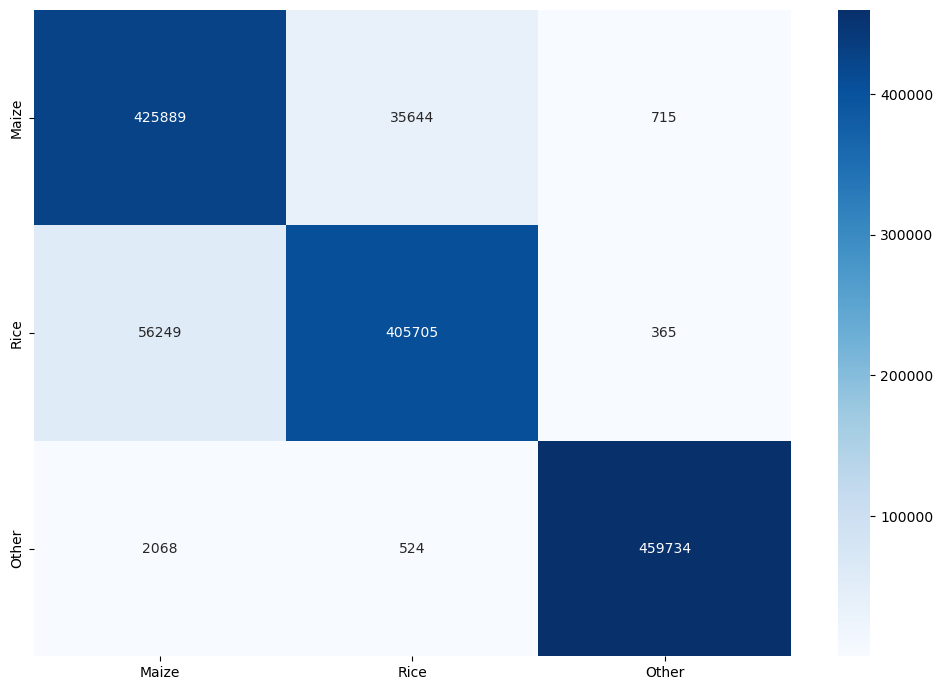

In [408]:
df_cm_rf = pd.DataFrame(confusion_rf, index = all_classes, columns = all_classes)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_rf, annot=True,fmt='d',cmap=plt.cm.Blues)
save_fig("Random_forest_aug_cm")

In [410]:
# measure accuracy
print('Accuracy: %.3f' % metrics.accuracy_score(y_true=y_test_aug, y_pred=y_pred_rf))
print('Recall: %.3f' % metrics.recall_score(y_true=y_test_aug, y_pred=y_pred_rf, average='weighted'))
print('Precision: %.3f' % metrics.precision_score(y_true=y_test_aug, y_pred=y_pred_rf, average='weighted'))
print('F1-Score: %.3f' % metrics.f1_score(y_true=y_test_aug, y_pred=y_pred_rf, average='weighted'))

Accuracy: 0.931
Recall: 0.931
Precision: 0.932
F1-Score: 0.931


In [411]:
# Save model as pkl file 
pickle.dump(rf_cv, open('models/CC/rf_cv.pkl', 'wb'))
#pickled_model = pickle.load(open('models/CC/rf_cv.pkl', 'rb'))
#pickled_model.predict(X_test_aug)

### XGBoost (extreme Gradient Boosting) Classifier

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ytrain = le.fit_transform(y_train_aug)
ytest = le.fit_transform(y_test_aug)

In [7]:
# Save the scaler object
with open('models/CC/encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

In [29]:
print(ytrain.shape)
print(ytest.shape)

(5547571,)
(1386893,)


In [32]:
xgbc = XGBClassifier(n_estimators = 1000, tree_method = "hist", device = "cuda", random_state=42)
param_cv = {"gamma": [0], "learning_rate": [0.08], "max_depth": [20]}   #, 18, 20, 0.1, 0.3, 0.001, 0.01
xgb_cv = set_rand(xgbc, param_cv)
xgb_cv.get_params()

{'cv': 10,
 'error_score': nan,
 'estimator__objective': 'binary:logistic',
 'estimator__base_score': None,
 'estimator__booster': None,
 'estimator__callbacks': None,
 'estimator__colsample_bylevel': None,
 'estimator__colsample_bynode': None,
 'estimator__colsample_bytree': None,
 'estimator__device': 'cuda',
 'estimator__early_stopping_rounds': None,
 'estimator__enable_categorical': False,
 'estimator__eval_metric': None,
 'estimator__feature_types': None,
 'estimator__gamma': None,
 'estimator__grow_policy': None,
 'estimator__importance_type': None,
 'estimator__interaction_constraints': None,
 'estimator__learning_rate': None,
 'estimator__max_bin': None,
 'estimator__max_cat_threshold': None,
 'estimator__max_cat_to_onehot': None,
 'estimator__max_delta_step': None,
 'estimator__max_depth': None,
 'estimator__max_leaves': None,
 'estimator__min_child_weight': None,
 'estimator__missing': nan,
 'estimator__monotone_constraints': None,
 'estimator__multi_strategy': None,
 'estima

In [33]:
print(datetime.datetime.now())
with parallel_backend('multiprocessing'):
    xgb_cv.fit(X_train_aug, ytrain)
print(datetime.datetime.now())

2024-01-30 22:01:20.319058
Fitting 10 folds for each of 1 candidates, totalling 10 fits
2024-01-31 01:19:09.800714


In [34]:
print_results(xgb_cv, X_test_aug, ytest)

(0.9429072652444365,
 {'max_depth': 20, 'learning_rate': 0.08, 'gamma': 0},
 0.9432184025732339)

In [35]:
print(datetime.datetime.now())
y_pred_xgb = xgb_cv.predict(X_test_aug)
print(datetime.datetime.now())

2024-01-31 02:25:50.550513
2024-01-31 02:25:53.568213


In [37]:
# evaluation: Confusion Matrix
confusion_xgb = metrics.confusion_matrix(y_true = ytest, y_pred = y_pred_xgb)
confusion_xgb

array([[425850,  36391,      7],
       [ 42182, 420125,     12],
       [    89,     69, 462168]], dtype=int64)

Saving figure xgb_aug_cm


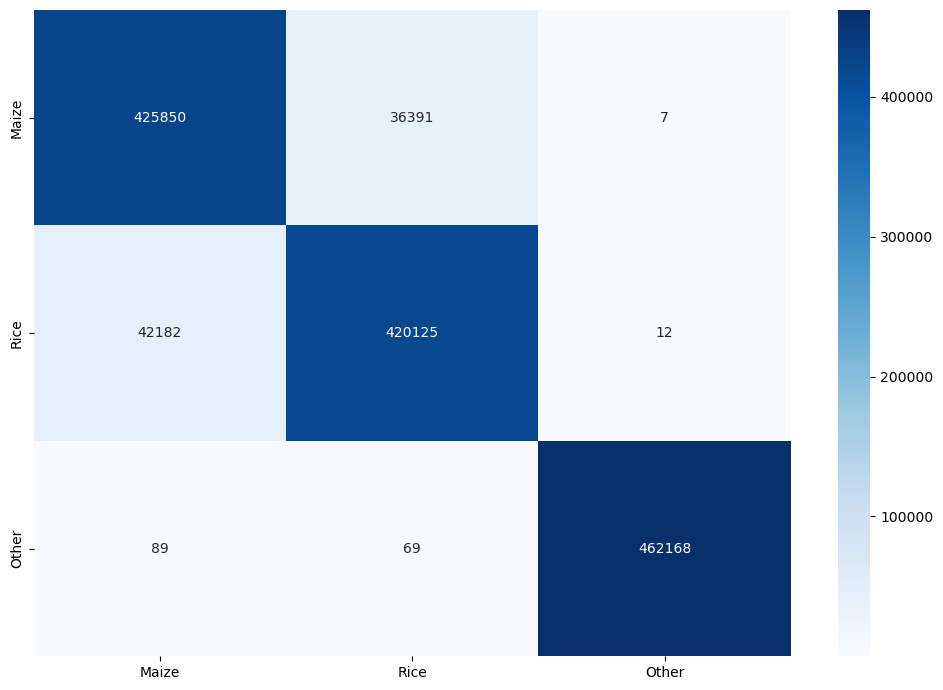

In [38]:
df_cm_xgb = pd.DataFrame(confusion_xgb, index = all_classes, columns = all_classes)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_xgb, annot=True,fmt='d',cmap=plt.cm.Blues)
save_fig("xgb_aug_cm")

In [39]:
# measure accuracy
print('Accuracy: %.3f' % metrics.accuracy_score(y_true=ytest, y_pred=y_pred_xgb))
print('Recall: %.3f' % metrics.recall_score(y_true=ytest, y_pred=y_pred_xgb, average='weighted'))
print('Precision: %.3f' % metrics.precision_score(y_true=ytest, y_pred=y_pred_xgb, average='weighted'))
print('F1-Score: %.3f' % metrics.f1_score(y_true=ytest, y_pred=y_pred_xgb, average='weighted'))

Accuracy: 0.943
Recall: 0.943
Precision: 0.943
F1-Score: 0.943


In [40]:
# Save model as pkl file 
pickle.dump(xgb_cv, open('models/CC/xgb_cv.pkl', 'wb'))
#pickled_model = pickle.load(open('models/CC/gb_cv.pkl', 'rb'))
#pickled_model.predict(X_test_aug)

### SVM RBF

In [17]:
import os
os.add_dll_directory("C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v12.3\\bin")

<AddedDllDirectory('C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v12.3\\bin')>

In [18]:
import thundersvm
from thundersvm import SVC

In [19]:
svc_rbf = thundersvm.SVC(gpu_id=0, kernel = "rbf")
param_cv = {"C" : [5, 8, 10], "gamma" : [0.5, 1, 3]}
svc_rbf_cv = set_rand(svc_rbf, param_cv)
svc_rbf_cv.get_params()

{'cv': 10,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__cache_size': None,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovo',
 'estimator__degree': 3,
 'estimator__gamma': 'auto',
 'estimator__gpu_id': 0,
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__max_mem_size': -1,
 'estimator__n_jobs': -1,
 'estimator__probability': False,
 'estimator__random_state': None,
 'estimator__shrinking': False,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'estimator': SVC(),
 'n_iter': 10,
 'n_jobs': 5,
 'param_distributions': {'C': [10, 20, 30], 'gamma': [0.1, 1, 5]},
 'pre_dispatch': '2*n_jobs',
 'random_state': None,
 'refit': True,
 'return_train_score': False,
 'scoring': 'accuracy',
 'verbose': 10}

In [ ]:
print(datetime.datetime.now())
with parallel_backend('multiprocessing'):
    svc_rbf_cv.fit(X_train_aug, y_train_aug)
print(datetime.datetime.now())

2024-02-04 11:21:01.049646
Fitting 10 folds for each of 9 candidates, totalling 90 fits


In [ ]:
print_results(svc_rbf_cv, X_test_aug, y_test_aug)

In [ ]:
print(datetime.datetime.now())
y_pred_svc = svc_rbf_cv.predict(X_test_aug)
print(datetime.datetime.now())

In [22]:
def random_searchrbf(X_train_aug, X_test_aug, y_train_aug, y_test_aug):
    results = []

    for C in [5, 8, 10]:
        for gamma in [1]:
            try:
                model = thundersvm.SVC(
                    gpu_id=0,
                    kernel="rbf",
                    C=C,
                    gamma=gamma
                )
                model.fit(X_train_aug, y_train_aug)
                y_pred_svc = model.predict(X_test_aug)
                result = metrics.accuracy_score(y_true=y_test_aug, y_pred=y_pred_svc)
        
                results.append((C, gamma, result))
            except Exception as e:
                print(f"Exception in random_search: {e}")

    return results

In [23]:
# Call the function to get the results
print(datetime.datetime.now())
svr_random_search = random_searchrbf(X_train_aug, X_test_aug, y_train_aug, y_test_aug)
print(svr_random_search)
# Find the best result based on the mean accuracy
best_result = max(svr_random_search, key=lambda x: x[2])
best_C, best_gamma, best_performance = best_result

print(f"Best C: {best_C}, Best Gamma: {best_gamma}, Best Performance: {best_performance}")
print(datetime.datetime.now())

2024-02-10 09:05:15.232138
[(5, 1, 0.9314568607671969), (8, 1, 0.932643686282936), (10, 1, 0.9331621112803944)]
Best C: 10, Best Gamma: 1, Best Performance: 0.9331621112803944
2024-02-11 19:26:09.430248


In [24]:
svc_rbf_gpu = thundersvm.SVC(gpu_id=0, C=10, gamma=1, kernel='rbf')
print(datetime.datetime.now())
svc_rbf_gpu.fit(X_train_aug, y_train_aug)
print(datetime.datetime.now())
# Evaluate the model on the entire dataset
y_pred_svc = svc_rbf_gpu.predict(X_test_aug)
print(datetime.datetime.now())

2024-02-11 23:19:09.977981
2024-02-12 10:17:49.565658
2024-02-12 11:03:04.475803


In [25]:
# measure accuracy
metrics.accuracy_score(y_true=y_test_aug, y_pred=y_pred_svc)

0.9331621112803944

In [26]:
# evaluation: Confusion Matrix
confusion_svmr = metrics.confusion_matrix(y_true = y_test_aug, y_pred = y_pred_svc)
confusion_svmr

array([[424905,  37138,    205],
       [ 51371, 410805,    143],
       [  1933,   1907, 458486]], dtype=int64)

Saving figure svm_rbf_aug_cm


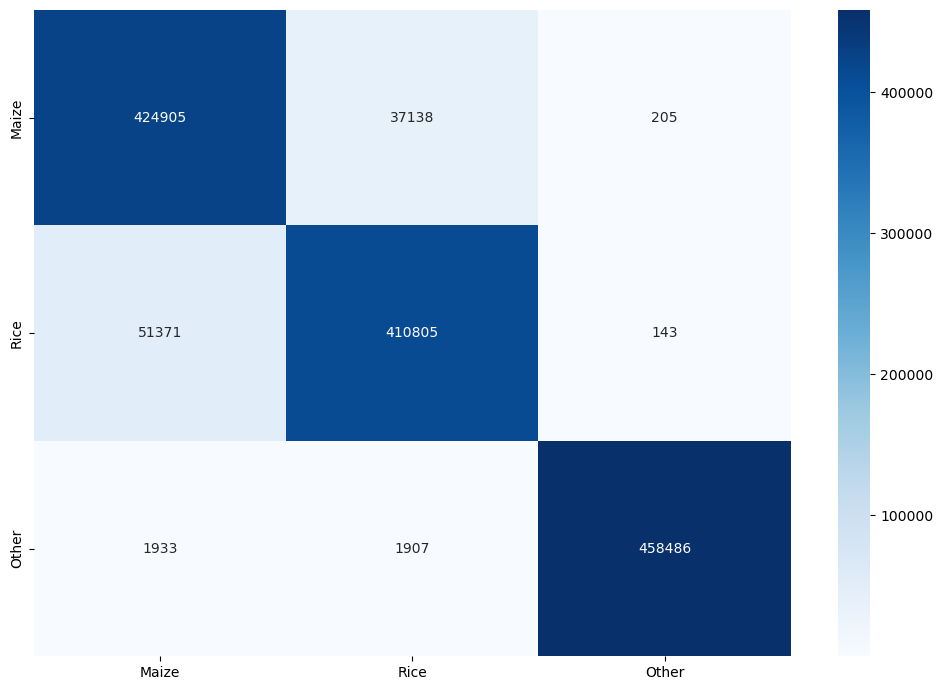

In [27]:
df_cm_svmr = pd.DataFrame(confusion_svmr, index = all_classes, columns = all_classes)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_svmr, annot=True,fmt='d',cmap=plt.cm.Blues)
save_fig("svm_rbf_aug_cm")

In [28]:
# measure accuracy
print('Accuracy: %.3f' % metrics.accuracy_score(y_true=y_test_aug, y_pred=y_pred_svc))
print('Recall: %.3f' % metrics.recall_score(y_true=y_test_aug, y_pred=y_pred_svc, average='weighted'))
print('Precision: %.3f' % metrics.precision_score(y_true=y_test_aug, y_pred=y_pred_svc, average='weighted'))
print('F1-Score: %.3f' % metrics.f1_score(y_true=y_test_aug, y_pred=y_pred_svc, average='weighted'))

Accuracy: 0.933
Recall: 0.933
Precision: 0.934
F1-Score: 0.933


In [30]:
# Save model as pkl file 
pickle.dump(svc_rbf_gpu, open('models/CC/svc_rbf_cv.pkl', 'wb'))
#pickled_model = pickle.load(open('models/CC/svc_rbf_cv.pkl', 'rb'))
#pickled_model.predict(X_test_aug)

### LSTM

In [8]:
# Reshape the X shape to fit in LSTM (add one dimension)
train_X = X_train_aug.values.reshape(X_train_aug.shape[0],X_train_aug.shape[1],1)
test_X = X_test_aug.values.reshape(X_test_aug.shape[0],X_test_aug.shape[1],1)

In [9]:
# Change Y values to be from 0 to 2 instead of 1 to 3
y_train_mod = y_train_aug - 1
y_test_mod = y_test_aug - 1

In [10]:
print(train_X.shape)
print(test_X.shape)

(5547571, 24, 1)
(1386893, 24, 1)


In [11]:
# Define the LSTM model
model = Sequential()
model.add(layers.Bidirectional(layers.LSTM(16, return_sequences=True), input_shape=(24, 1)))
model.add(layers.Dropout(0.2))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Dropout(0.2))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
model.add(layers.Dropout(0.2))
model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))  # Return sequences for the last LSTM layer
model.add(layers.Dropout(0.2))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))  # Return sequences for the last LSTM layer
model.add(layers.Dropout(0.2))
model.add(layers.Bidirectional(layers.LSTM(16, return_sequences=False)))  # No return_sequences for the last LSTM layer
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 24, 32)           2304      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 32)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 24, 64)           16640     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 24, 64)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 24, 128)          66048     
 nal)                                                            
                                                        

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [21]:
#train 
print(datetime.datetime.now())
history = model.fit(train_X, y_train_mod, batch_size=2048, epochs=100, validation_split=0.1)
print(datetime.datetime.now())

2024-02-12 16:53:23.893812
Epoch 1/100
2438/2438 [==============================] - 3325s 1s/step - loss: 0.8801 - accuracy: 0.5860 - val_loss: 0.6742 - val_accuracy: 0.7211
Epoch 2/100
2438/2438 [==============================] - 3561s 1s/step - loss: 0.6816 - accuracy: 0.7205 - val_loss: 0.5515 - val_accuracy: 0.7835
Epoch 3/100
2438/2438 [==============================] - 3508s 1s/step - loss: 0.5274 - accuracy: 0.7971 - val_loss: 0.4108 - val_accuracy: 0.8471
Epoch 4/100
2438/2438 [==============================] - 3489s 1s/step - loss: 0.4344 - accuracy: 0.8379 - val_loss: 0.3407 - val_accuracy: 0.8743
Epoch 5/100
2438/2438 [==============================] - 3531s 1s/step - loss: 0.3992 - accuracy: 0.8523 - val_loss: 0.3203 - val_accuracy: 0.8827
Epoch 6/100
2438/2438 [==============================] - 3542s 1s/step - loss: 0.3592 - accuracy: 0.8686 - val_loss: 0.3045 - val_accuracy: 0.8897
Epoch 7/100
2438/2438 [==============================] - 3766s 2s/step - loss: 0.3386 - acc

In [22]:
preds = model.predict(test_X)

In [24]:
val_pred = np.argmax(model.predict(test_X), axis=-1)

In [25]:
preds.argmax(axis=1)

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [26]:
# evaluation: Confusion Matrix
confusion_lstm = metrics.confusion_matrix(y_true = y_test_mod, y_pred = val_pred)
confusion_lstm

array([[427263,  34959,     26],
       [ 50203, 412064,     52],
       [   678,    646, 461002]], dtype=int64)

Saving figure lstm_aug_cm


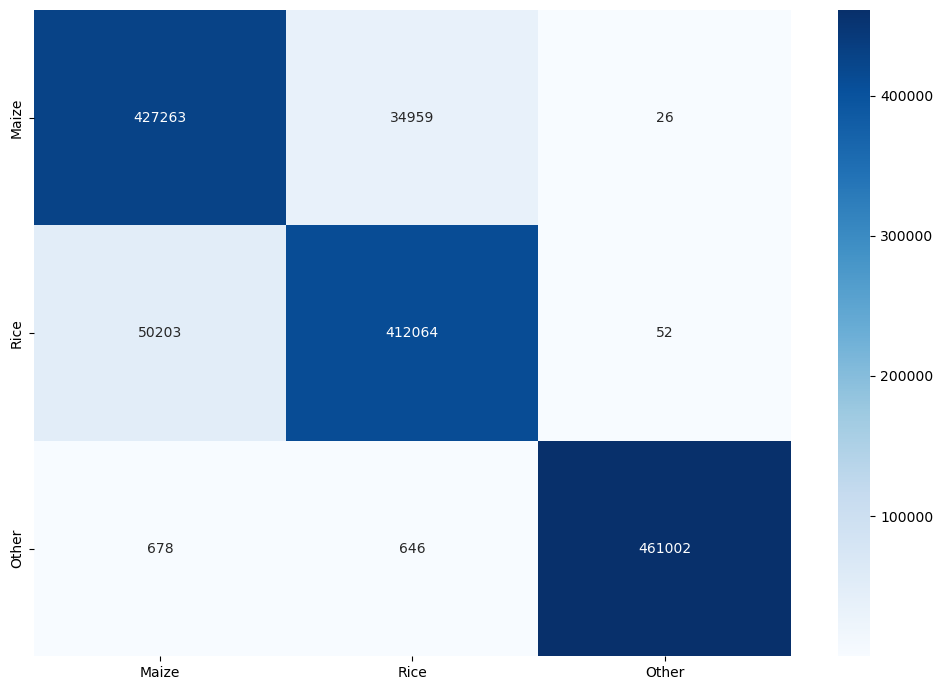

In [27]:
df_cm_lstm = pd.DataFrame(confusion_lstm, index = all_classes, columns = all_classes)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_lstm, annot=True,fmt='d',cmap=plt.cm.Blues)
save_fig("lstm_aug_cm")

In [29]:
# measure accuracy
print('Accuracy: %.3f' % metrics.accuracy_score(y_true=y_test_mod, y_pred=val_pred))
print('Recall: %.3f' % metrics.recall_score(y_true=y_test_mod, y_pred=val_pred, average='weighted'))
print('Precision: %.3f' % metrics.precision_score(y_true=y_test_mod, y_pred=val_pred, average='weighted'))
print('F1-Score: %.3f' % metrics.f1_score(y_true=y_test_mod, y_pred=val_pred, average='weighted'))

Accuracy: 0.938
Recall: 0.938
Precision: 0.938
F1-Score: 0.938


In [36]:
# Save model as pkl file
model.save('models/CC/lstm_model.keras')
model.save('models/CC/lstm_model.h5', save_format='h5')
# It can be used to reconstruct the model identically.
#reconstructed_model = keras.models.load_model("models/CC/lstm_model.keras")
# Let's check:
#np.testing.assert_allclose(
#    model.predict(test_input), reconstructed_model.predict(test_input)
#)

In [42]:
def unpack(model, training_config, weights):
    restored_model = deserialize(model)
    if training_config is not None:
        restored_model.compile(
            **saving_utils.compile_args_from_training_config(
                training_config
            )
        )
    restored_model.set_weights(weights)
    return restored_model

# Hotfix function
def make_keras_picklable():

    def __reduce__(self):
        model_metadata = saving_utils.model_metadata(self)
        training_config = model_metadata.get("training_config", None)
        model = serialize(self)
        weights = self.get_weights()
        return (unpack, (model, training_config, weights))

    cls = Model
    cls.__reduce__ = __reduce__

# Run the function
make_keras_picklable()

In [43]:
# Save model as pkl file 
pickle.dump(model, open('models/CC/lstm_model.pkl', 'wb'))
#pickled_model = pickle.load(open('models/CC/model.pkl', 'rb'))
#pickled_model.predict(X_test)